In [14]:
import numpy as np
import pickle
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('/Users/vsriniv/Documents/Research/Github/PatchSim')
import patchsim as sim
import hyperopt
import seaborn as sns
from hyperopt import hp, Trials
from tqdm import tqdm

In [23]:
gt = pd.read_csv('../data/Ebola_Updated_Apr9.csv',delimiter=',',dtype={'date':str})
gt['Date'] = gt.date.apply(lambda x: datetime.strptime(x,'%Y%m%d'))
gt = gt[gt.Date>=datetime.strptime('20180805','%Y%m%d')] ## Starting on August 5th, the first non-NaN value
gt['Ob_Day'] = gt.Date.apply(lambda x : (x - datetime.strptime('20180805','%Y%m%d')).days)
#gt['Ob_Week'] = gt.Ob_Day.apply(lambda x: x//7)

# Get top 10 healthzones
key_hzs = gt[gt.Date==gt.Date.max()][['health_zone','total_c']].sort_values('total_c',ascending=False).head(11)['health_zone'].values
key_hzs = sorted(list(set(key_hzs) - {'all'}))

T = len(gt[gt.health_zone=='all'])

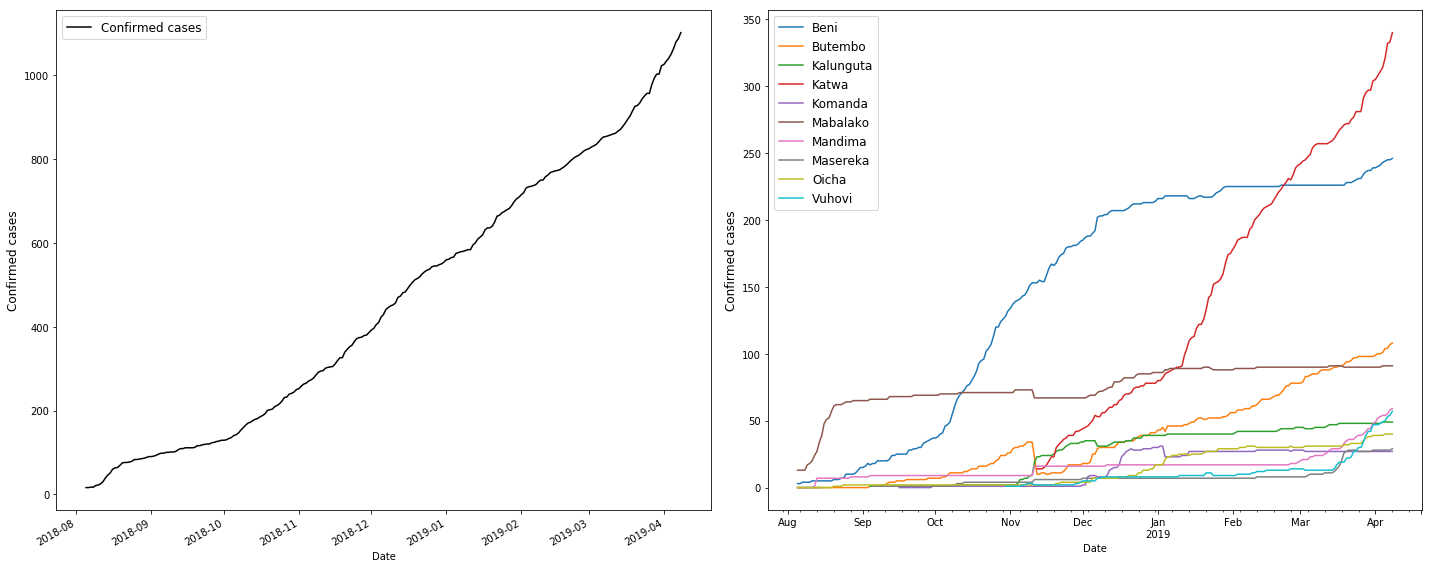

In [24]:
f, axarr = plt.subplots(1,2, figsize=(20,8))
gt[gt.health_zone=='all'].plot(x='Date',y='total_c',ax=axarr[0],color='k',label='Confirmed cases')
axarr[0].set_ylabel('Confirmed cases',fontsize=12)
axarr[0].legend(loc=2,fontsize=12)

gt[gt.health_zone.isin(key_hzs)].pivot(index='Date',columns='health_zone',values='total_c').plot(ax=axarr[1])
axarr[1].set_ylabel('Confirmed cases',fontsize=12)
axarr[1].legend(fontsize=12)

plt.tight_layout()